In [1]:
import numpy
from scipy import linalg, special, integrate
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import pyplot

from tqdm.notebook import tqdm

import joblib

import born_markov as bmme

In [ ]:
d_ops, d_dags = bmme.generate_fermionic_ops(2)
d1_op, d1_dag, d2_op, d2_dag = d_ops[0], d_dags[0], d_ops[1], d_dags[1]

omega1 = .02
omega2 = .02
lamda1 = .01
lamda2 = .01
epsilon = .0
hopping = .2
repulsion = .0
Gamma = .01
Gammas = numpy.array([[[Gamma, 0], [0, 0]], [[0, 0], [0, Gamma]]])
T = .026 / bmme.k_B
voltage = 0.2

def func_H_s(x):
    H_s = .5 * (omega1**2 * x[0]**2 + omega2**2 * x[1]**2) * numpy.identity(d1_op.shape[0])
    H_s += epsilon * d1_dag @ d1_op
    H_s -= epsilon * d2_dag @ d2_op
    H_s += lamda1 * x[0] * (d1_dag @ d2_op + d2_dag @ d1_op)
    H_s += lamda2 * x[1] * (d1_dag @ d1_op - d2_dag @ d2_op)
    H_s -= hopping * (d1_dag @ d2_op + d2_dag @ d1_op)
    H_s += repulsion * (d1_dag @ d1_op @ d2_dag @ d2_op)
    return H_s

def func_ddx_H_s(k, x):
    if k == 0:
        ddx = omega1**2 * x[0] * numpy.identity(d1_op.shape[0])
        ddx += lamda1 * (d1_dag @ d2_op + d2_dag @ d1_op)
        return ddx
    elif k == 1:
        ddx = omega2**2 * x[1] * numpy.identity(d1_op.shape[0])
        ddx += lamda2 * (d1_dag @ d1_op - d2_dag @ d2_op)
        return ddx

def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, val, d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, method="analytic", include_digamma=False)

def my_func2(i, val):
    solver = bmme.general_solver(func_H_s(val), d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, include_digamma=False)
    r, L = solver.find_steady_state()
    return solver.V @ r @ solver.V_dag

x1 = numpy.linspace(-200, 200, 2000)
x2 = numpy.linspace(-200, 200, 2000)

X = numpy.array(numpy.meshgrid(x1, x2)).T.reshape(-1, 2)

mean_force = numpy.zeros((len(X), 2), dtype=numpy.float64)
friction = numpy.zeros((len(X), 2, 2), dtype=numpy.float64)
correlation = numpy.zeros((len(X), 2, 2), dtype=numpy.float64)

results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(X)))

for i in range(len(results)):
    mean_force[i] = results[i][0].real
    friction[i] = results[i][1].real
    correlation[i] = results[i][2].real

numpy.save("data/anderson_2cl/mean_force_" + str(lamda1) + "_voltage_" + str(voltage) + ".npy", numpy.array([X[:,0], X[:,1], mean_force[:,0], mean_force[:,1]]))
numpy.save("data/anderson_2cl/friction_" + str(lamda1) + "_voltage_" + str(voltage) + ".npy", numpy.array([X[:,0], X[:,1], friction[:,0,0], friction[:,0,1], friction[:,1,0], friction[:,1,1]]))
numpy.save("data/anderson_2cl/correlation_" + str(lamda1) + "_voltage_" + str(voltage) + ".npy", numpy.array([X[:,0], X[:,1], correlation[:,0,0], correlation[:,0,1], correlation[:,1,0], correlation[:,1,1]]))

In [15]:
display_voltage = 1.0

import time

start = time.time()
friction0 = numpy.load("data/anderson_2cl/friction_0.01_voltage_" + str(display_voltage) + ".npy")
mean_force0 = numpy.load("data/anderson_2cl/mean_force_0.01_voltage_" + str(display_voltage) + ".npy")
correlation0 = numpy.load("data/anderson_2cl/correlation_0.01_voltage_" + str(display_voltage) + ".npy")
print(time.time() - start)

if len(mean_force0) == 6:
    mean_force0 = mean_force0[0:4,:]
    numpy.save("data/anderson_2cl/mean_force_0.01_voltage_" + str(display_voltage) + ".npy", mean_force0)
    print("Wrong size")

#start = time.time()
#friction0 = numpy.loadtxt("data/anderson_2cl/friction_0.01_voltage_" + str(display_voltage))
#mean_force0 = numpy.loadtxt("data/anderson_2cl/mean_force_0.01_voltage_" + str(display_voltage))
#correlation0 = numpy.loadtxt("data/anderson_2cl/correlation_0.01_voltage_" + str(display_voltage))
#print(time.time() - start)
#numpy.save("data/anderson_2cl/friction_0.01_voltage_" + str(display_voltage) + ".npy", friction0)
#numpy.save("data/anderson_2cl/mean_force_0.01_voltage_" + str(display_voltage) + ".npy", mean_force0)
#numpy.save("data/anderson_2cl/correlation_0.01_voltage_" + str(display_voltage) + ".npy", correlation0)

reshapeN = 2000

grid_x1 = mean_force0[0].reshape(reshapeN, reshapeN)
grid_x2 = mean_force0[1].reshape(reshapeN, reshapeN)
F_1 = mean_force0[2].reshape(reshapeN, reshapeN)
F_2 = mean_force0[3].reshape(reshapeN, reshapeN)
gamma_11 = friction0[2].reshape(reshapeN, reshapeN)
gamma_12 = friction0[3].reshape(reshapeN, reshapeN)
gamma_21 = friction0[4].reshape(reshapeN, reshapeN)
gamma_22 = friction0[5].reshape(reshapeN, reshapeN)
D_11 = correlation0[2].reshape(reshapeN, reshapeN)
D_12 = correlation0[3].reshape(reshapeN, reshapeN)
D_21 = correlation0[4].reshape(reshapeN, reshapeN)
D_22 = correlation0[5].reshape(reshapeN, reshapeN)

def get_index_lo(x):
    index_low = grid_x1[0,0]
    index_high = grid_x1[-1,0]
    index_1 = int((x[0] - index_low) * len(grid_x1[:,0]) / (index_high - index_low))
    
    index_low = grid_x2[0,0]
    index_high = grid_x2[0,-1]
    index_2 = int((x[1] - index_low) * len(grid_x2[0,:]) / (index_high - index_low))
    
    return (index_1, index_2)

def get_lin_int(x, X):
    index_low = grid_x1[0,0]
    index_high = grid_x1[-1,0]
    index_1l = int((x[0] - index_low) * len(grid_x1[:,0]) / (index_high - index_low))
    index_1h = index_1l + 1
    x_11 = grid_x1[index_1l, 0]
    x_12 = grid_x1[index_1h, 0]
    
    index_low = grid_x2[0,0]
    index_high = grid_x2[0,-1]
    index_2l = int((x[1] - index_low) * len(grid_x2[0,:]) / (index_high - index_low))
    index_2h = index_2l + 1
    x_21 = grid_x2[0, index_2l]
    x_22 = grid_x2[0, index_2h]
    
    x1 = x[0]
    x2 = x[1]
    
    result = (x_12 - x1) * (x_22 - x2) * X[index_1l, index_2l]
    result += (x1 - x_11) * (x_22 - x2) * X[index_1h, index_2l]
    result += (x_12 - x1) * (x2 - x_21) * X[index_1l, index_2h]
    result += (x1 - x_11) * (x2 - x_21) * X[index_1h, index_2h]
    return result / ((x_12 - x_11) * (x_22 - x_21))
    
    
def solve(x_0, v_0, N, dt=1e-2):
    x = numpy.zeros((N+1, 2))
    x[0] = x_0
    v = v_0
    for i in range(N):
        index = get_index_lo(x[i])
        dx = v
        x[i+1] = x[i] + dx * dt
        #print(F_1[index])
        dv1 = F_1[index] - gamma_11[index] * v[0] - gamma_12[index] * v[1] + numpy.random.randn
        dv2 = F_2[index] - gamma_21[index] * v[0] - gamma_22[index] * v[1]
        v += numpy.array([dv1, dv2]) * dt
    return x

def solve_mbaoab(x_0, v_0, N, dt=1e-2, K=10):
    factor = numpy.sqrt(dt / K)
    x = numpy.zeros((N+1, 2))
    x[0] = x_0
    v = v_0
    for i in tqdm(range(N)):
        x[i+1] = x[i] + 0.5 * dt * v
        F = numpy.array([get_lin_int(x[i+1], F_1), get_lin_int(x[i+1], F_2)])
        gamma = numpy.array([[get_lin_int(x[i+1], gamma_11), get_lin_int(x[i+1], gamma_12)], 
                             [get_lin_int(x[i+1], gamma_21), get_lin_int(x[i+1], gamma_22)]])
        sigma = numpy.array([[get_lin_int(x[i+1], D_11), get_lin_int(x[i+1], D_12)],
                             [get_lin_int(x[i+1], D_21), get_lin_int(x[i+1], D_22)]])
        v += 0.5 * dt * F
        G = linalg.expm(-dt * gamma / (2 * K))
        for j in range(K):
            v = G @ G @ v + factor * G @ sigma @ numpy.random.randn(2)
        v += 0.5 * dt * F
        x[i+1] += 0.5 * dt * v
    return x

2.0470430850982666


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Use the colorbar set_ticks() method instead.


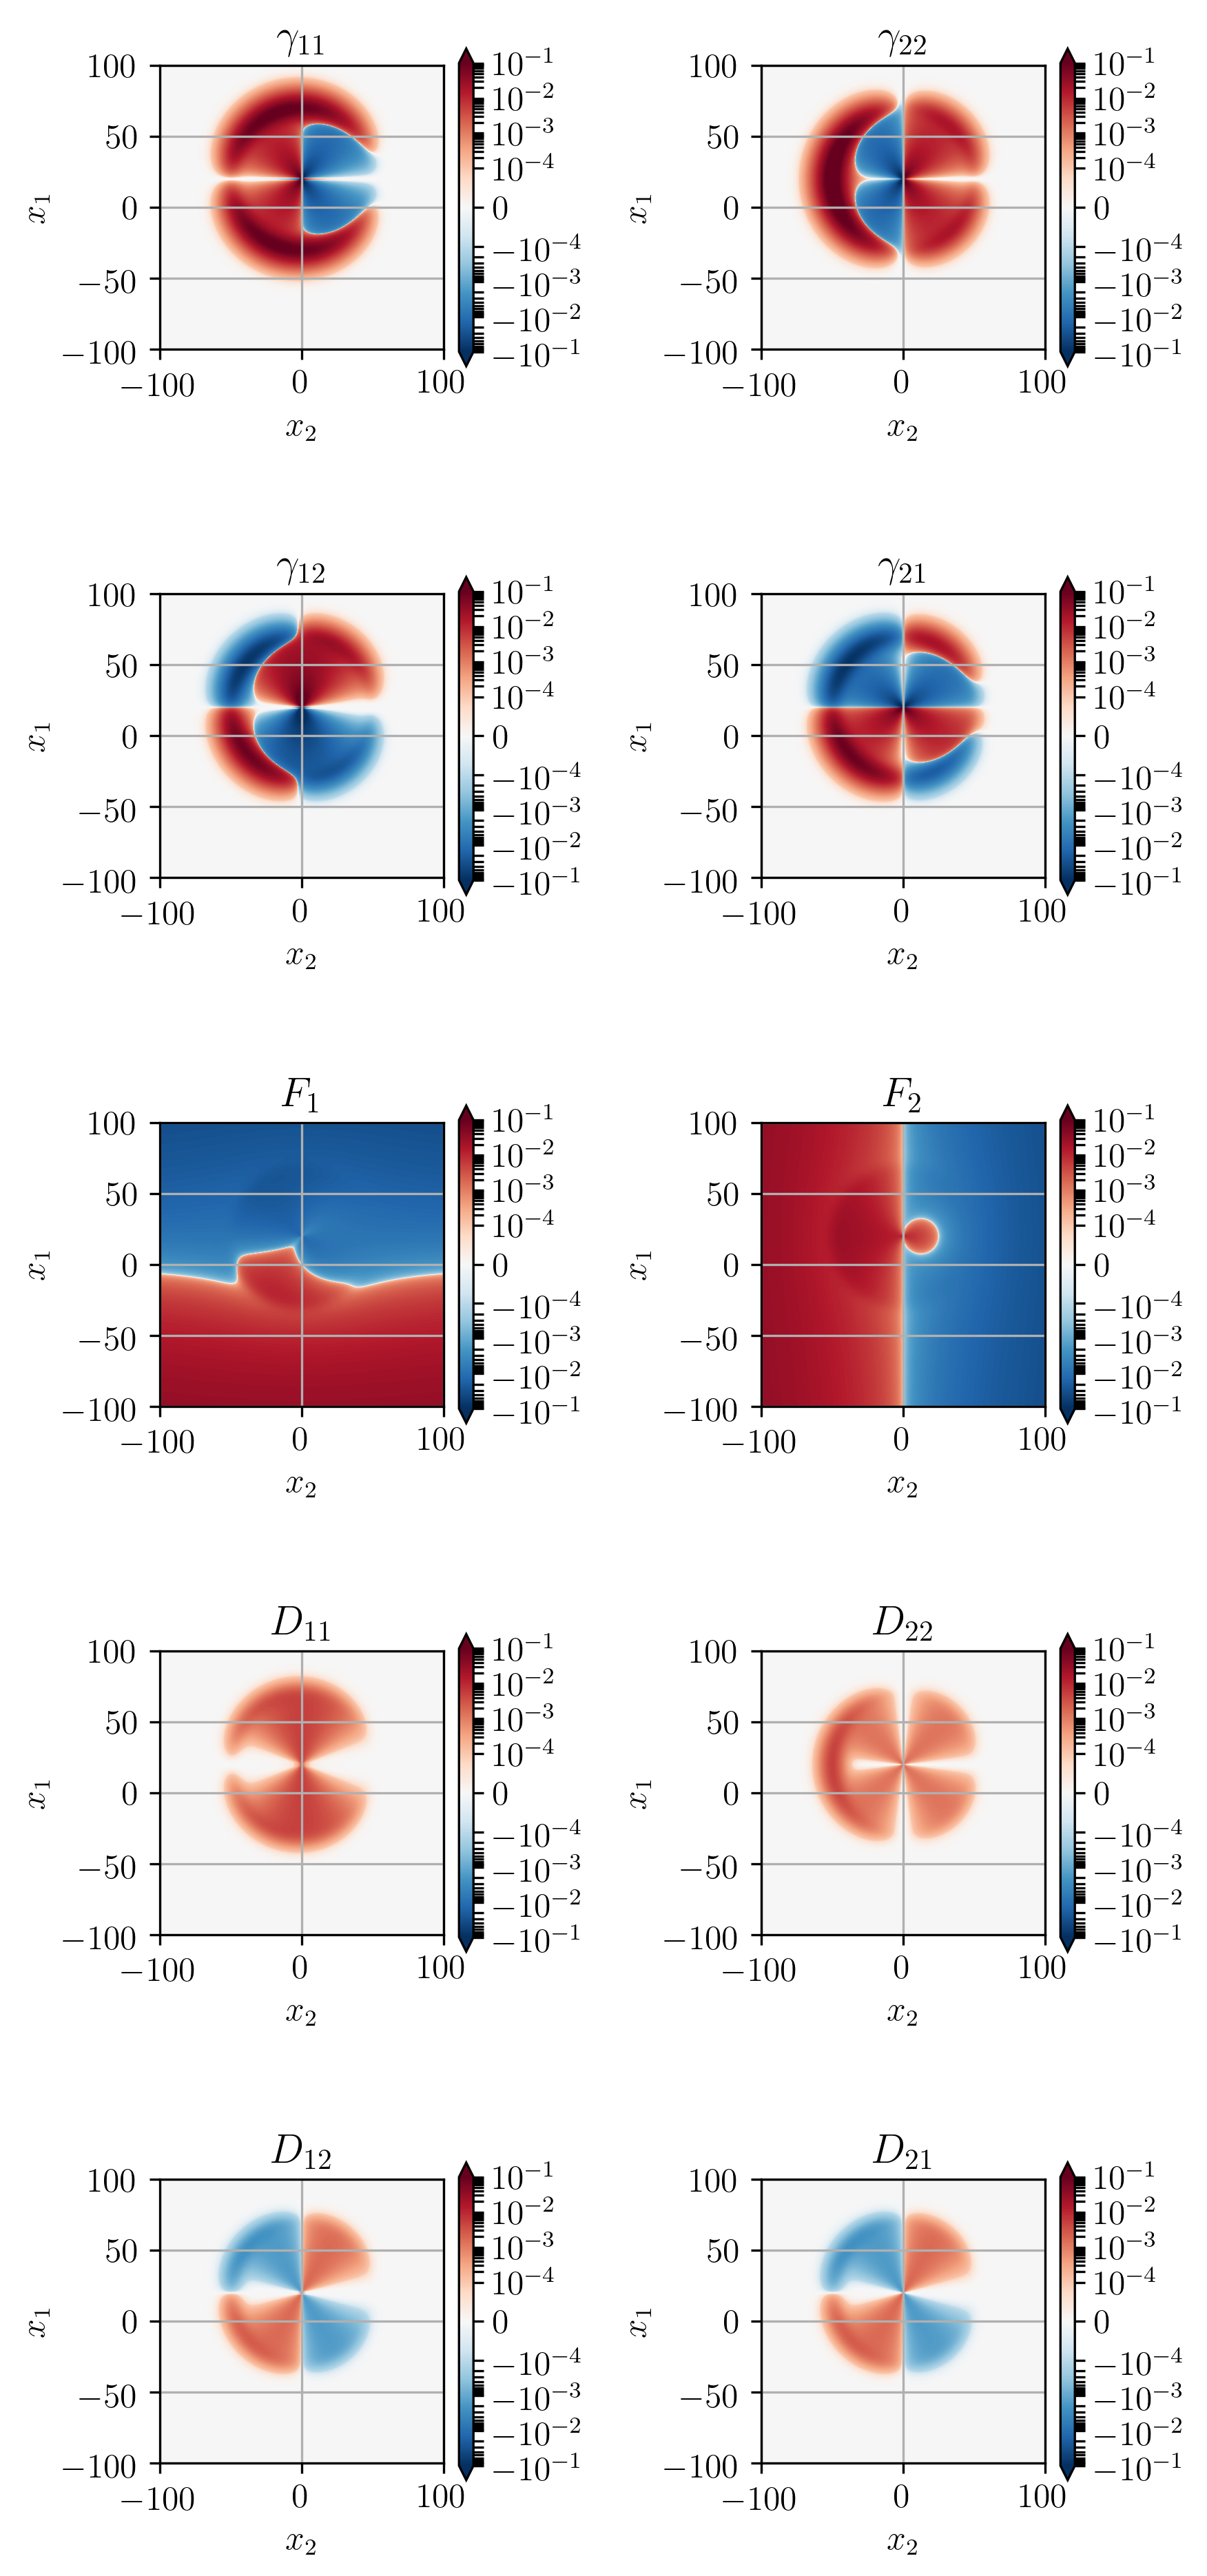

In [16]:
fig = pyplot.figure(figsize=(6, 13), tight_layout=True)
ax1 = fig.add_subplot(5, 2, 1)
ax2 = fig.add_subplot(5, 2, 2)
ax3 = fig.add_subplot(5, 2, 3)
ax4 = fig.add_subplot(5, 2, 4)
ax5 = fig.add_subplot(5, 2, 5)
ax6 = fig.add_subplot(5, 2, 6)
ax7 = fig.add_subplot(5, 2, 7)
ax8 = fig.add_subplot(5, 2, 8)
ax9 = fig.add_subplot(5, 2, 9)
ax10 = fig.add_subplot(5, 2, 10)

def plot_two_axes(ax, data, label):
    posa = ax.pcolormesh(grid_x2, grid_x1, numpy.log(data), cmap="Reds")# extent=[grid_x1[0,0],grid_x1[-1,0],grid_x2[0,0],grid_x2[0,-1]], cmap="Reds", origin="lower")
    posb = ax.imshow(numpy.log(-data), extent=[grid_x1[0,0],grid_x1[-1,0],grid_x2[0,0],grid_x2[0,-1]], cmap="Blues", origin="lower")
    cba = fig.colorbar(posa, ax=ax, extend="both")
    cbb = fig.colorbar(posb, ax=ax, shrink=.7)
    ax.set_xlabel("$x_2$")
    ax.set_ylabel("$x_1$")
    ax.set_xlim(-50, 50)
    ax.set_xticks([-40, -20, 0, 20, 40])
    ax.set_ylim(-50, 50)
    ax.set_yticks([-40, -20, 0, 20, 40])
    ax.grid()
    #ax1.text(-5., 1., "\\textbf{(a)}", ha="center", va="bottom")
    #cb1.ax.set_yticks([.0, .2, .4, .6, .8])
    ax.set_title(label)
    
def plot_comb_axes(ax, data, label):
    pos = ax.imshow(data, norm=matplotlib.colors.SymLogNorm(linthresh=1e-4, vmin=-.1, vmax=.1), cmap="RdBu_r", extent=[grid_x1[0,0],grid_x1[-1,0],grid_x2[0,0],grid_x2[0,-1]], origin="lower")
    cb = fig.colorbar(pos, ax=ax, extend="both", fraction=.046)
    ax.set_xlabel("$x_2$")
    ax.set_ylabel("$x_1$")
    ax.set_xlim(-100, 100)
    #ax.set_xticks([-40, -20, 0, 20, 40])
    ax.set_ylim(-100, 100)
    #ax.set_yticks([-40, -20, 0, 20, 40])
    ax.grid()
    #ax1.text(-5., 1., "\\textbf{(a)}", ha="center", va="bottom")
    cb.ax.set_yticks([-1e-1, -1e-3, 0, 1e-3, 1e-1])
    ax.set_title(label)

plot_comb_axes(ax1, gamma_11, "$\\gamma_{11}$")

plot_comb_axes(ax2, gamma_22, "$\\gamma_{22}$")

plot_comb_axes(ax3, gamma_12, "$\\gamma_{12}$")

plot_comb_axes(ax4, gamma_21, "$\\gamma_{21}$")

plot_comb_axes(ax5, F_1, "$F_1$")

plot_comb_axes(ax6, F_2, "$F_2$")

plot_comb_axes(ax7, D_11, "$D_{11}$")

plot_comb_axes(ax8, D_22, "$D_{22}$")

plot_comb_axes(ax9, D_12, "$D_{12}$")

plot_comb_axes(ax10, D_21, "$D_{21}$")

#x_sol = solve_mbaoab(numpy.array([20.,-3.]), numpy.array([.0,.0]), 100000)
#ax1.plot(x_sol[:,1], x_sol[:,0], c="#ffaaaa")

pyplot.gcf().set_dpi(300)
pyplot.savefig("anderson_2cl_1.0V.pdf")
pyplot.show()